In [1]:
%cd ..

/home/den/dev/git/ozon-e-cup-2025


In [ ]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import (
    MultilabelStratifiedKFold,
    MultilabelStratifiedShuffleSplit,
)

In [ ]:
# Utils


def unique_value_counts(df, column):
    """
    Returns a DataFrame with unique values in the column, their counts, and percentage ratios.
    """
    counts = df[column].value_counts(dropna=False)
    percentages = counts / len(df) * 100
    result = pd.DataFrame({"count": counts, "percentage": percentages})
    return result

In [ ]:
train = pd.read_csv("data/2__train_with_flags_num_cat.csv")
train.shape

(197198, 79)

Хотим стратифицировать по

- таргету (resolution)
- категориальным фичам

    - категория товара (CommercialTypeName4)
    - название бренда (brand_name)

In [ ]:
unique_value_counts(train, "resolution")

,count,percentage
resolution,,
0,184146,93.381272
1,13052,6.618728


In [ ]:
unique_value_counts(train, "CommercialTypeName4")

,count,percentage
CommercialTypeName4,,
Дисплеи для телефонов,15002,7.607582
Аккумулятор для мобильного телефона,11965,6.067506
Корпуса для телефонов,11960,6.064970
Запчасти для телевизора,10192,5.168409
"Картридж, чернила, тонер",8570,4.345886
...,...,...
"Телевизор LG с диагональю экрана до 42,9 дюймов",2,0.001014
"Оригинальное зарядное устройство для игровой приставки, геймпада",1,0.000507
"Умное кольцо, умная визитка",1,0.000507


In [ ]:
unique_value_counts(train, "brand_name")

,count,percentage
brand_name,,
NaN,80531,40.837635
<RARE_BRAND_NAME>,7561,3.834217
iQZiP,6084,3.085224
ProFDetali,4811,2.439680
OEM,4275,2.167872
...,...,...
Oasis,1,0.000507
Libhof,1,0.000507
Yamaha,1,0.000507


Тут конечно категорий много, нам бы хотелось чтобы хотя какая-то часть самых популярных была стратифицированна.

<Axes: >

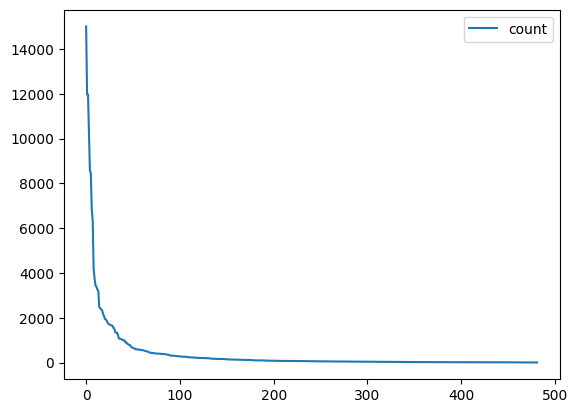

In [ ]:
train.CommercialTypeName4.value_counts().reset_index().plot()

<Axes: >

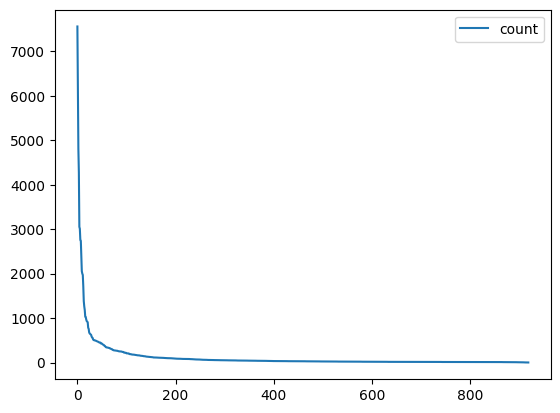

In [ ]:
train.brand_name.value_counts().reset_index().plot()

# Stratify using iterative-stratification package

Стратифицировать по нескольким колонкам (таргет, категория, бренд) с помощью train_test_split из sklearn не получится, так как они там пытаются разделить совместно, т.е. например чтобы были одинаковые *совместные* ratio у групп (таргет, категория, бренд).

А мы же хотим сделать независимую стратификацию. Т.е. нам важно сохранить ratio у (таргет) (категория) (бренд) по-отдельности.

In [ ]:
cols_to_strat = ["resolution", "brand_name_for_strat", "CommercialTypeName4_for_strat"]

In [ ]:
train["CommercialTypeName4_for_strat"] = train["CommercialTypeName4"].where(
    train["CommercialTypeName4"].map(train["CommercialTypeName4"].value_counts()) > 1000, "<OTHER>"
)

train.CommercialTypeName4_for_strat.nunique()

41

In [ ]:
train["brand_name_for_strat"] = train["brand_name"].where(
    train["brand_name"].map(train["brand_name"].value_counts()) > 500, "<OTHER>"
)

train.brand_name_for_strat.nunique()

37

In [ ]:
X = train
y = train[cols_to_strat]

In [ ]:
# Тут нельзя указать test_size, так как он будет определяться в зависимости от n_splits
# Таким образом, чтобы в итоге каждый объект хоть раз был в тестовой выборке (на любом из фолдов)
splitter = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# Если же хотим фиксированный test_size, то надо использовать MultilabelStratifiedShuffleSplit
splitter = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [ ]:
splits = []
for train_idx, val_idx in splitter.split(X, y):
    splits.append((train_idx, val_idx))

In [ ]:
# Проверка сплитов
for train_idx, val_idx in splits:
    # Что длины совпадают
    train_len = len(train_idx)
    val_len = len(val_idx)
    assert train_len + val_len == len(train)

    # Что индексы не пересекаются
    assert set(train_idx).isdisjoint(set(val_idx))

    # Что все объекты есть либо в обучающей, либо в валидационной выборке
    assert set(train_idx).union(set(val_idx)) == set(range(len(X)))

    # Проверим стратификацию по resolution
    train_res = train["resolution"].values[train_idx]
    val_res = train["resolution"].values[val_idx]
    orig_res = train["resolution"].values
    assert np.isclose(train_res.mean(), val_res.mean(), orig_res.mean(), atol=1e-4)

    # Проверим стратификацию по CommercialTypeName4
    train_com = train["CommercialTypeName4_for_strat"].iloc[train_idx]
    train_com_dict = {value: count for value, count in train_com.value_counts(normalize=True).items()}
    val_com = train["CommercialTypeName4_for_strat"].iloc[val_idx]
    val_com_dict = {value: count for value, count in val_com.value_counts(normalize=True).items()}
    orig_com = train["CommercialTypeName4_for_strat"]
    orig_com_dict = {value: count for value, count in orig_com.value_counts(normalize=True).items()}

    for value in orig_com_dict:
        assert np.isclose(
            train_com_dict.get(value, 0), val_com_dict.get(value, 0), orig_com_dict[value], atol=1e-2
        ), f"Stratification failed for CommercialTypeName4: {value}"

    # Проверим стратификацию по brand_name_for_strat
    train_brand = train["brand_name_for_strat"].iloc[train_idx]
    train_brand_dict = {value: count for value, count in train_brand.value_counts(normalize=True).items()}
    val_brand = train["brand_name_for_strat"].iloc[val_idx]
    val_brand_dict = {value: count for value, count in val_brand.value_counts(normalize=True).items()}
    orig_brand = train["brand_name_for_strat"]
    orig_brand_dict = {value: count for value, count in orig_brand.value_counts(normalize=True).items()}

    for value in orig_brand_dict:
        assert np.isclose(
            train_brand_dict.get(value, 0), val_brand_dict.get(value, 0), orig_brand_dict[value], atol=1e-2
        ), f"Stratification failed for brand_name_for_strat: {value}"